In [43]:
import scipy.io as sci
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

import hddm

### Separate based on response (flash first or beep first)

In [44]:
resppath = 'StabilityofPCommonData/NumerosityTaskUnformatted/*.mat'
respfiles = np.array(glob.glob(resppath))
datapath = 'StabilityofPCommonData/NumerosityTaskData/*.mat'
datafiles = np.array(glob.glob(datapath))

In [45]:
# filenames for f or b responses
respf = np.empty((1, 1))
respb = np.empty((1, 1))
for names in respfiles:
    mat = sci.loadmat(names)
    resp = mat['respCode']
    if(resp == "f"):
        respf = np.append(respf, names)
    else:
        respb = np.append(respb, names)
respf = respf[1:]
respb = respb[1:]

In [46]:
# index for flash first files(1 if yes 0 if no) 
# use for TaskData to pull data for subjects that reported flash first
indexf = list()
c = 0
for x in respfiles:
    if x in respf:
        indexf.append(c)
    c += 1
#respfiles[indexf]

# exclude files that are incomplete
dataf = datafiles[indexf]
missing = np.empty((1,1), dtype = int)

for i in np.arange(0, len(dataf)):
    mat = sci.loadmat(dataf[i])
    #print(len(mat['trialData']))
    if len(mat['trialData']) < 360:
        missing = np.append(missing, i)
        #print(len(mat['trialData']), i)
missing = missing[1:]
indexf = np.delete(indexf, missing)
print(indexf)

[ 1  3  6  7 14 15 16 17 22 23 27 28 29 35 44 50 52 53 57 58 60 61 66 67
 68 69 71 78 79 82 83 84 85 86 87 90 91 92 93 99]


### Extract trial data and response times for flash trials

In [73]:
# further subset into flash reported and insert indices for subject id  
dataf = datafiles[indexf]

subjidf = np.array([2,5,7,7,11,11,12,12,15,15,19,20,20,23,28,31,32,32,35,36,37,37,40,
                   40,41,41,42,50,50,53,53,54,54,57,57,60,60,61,61,64])
trialsf = np.empty((1,5))
for i in np.arange(0, len(dataf)):
    mat = sci.loadmat(dataf[i])
    arr = mat['trialData']
    # add subject id to the first column
    arr = np.insert(arr, 0, int(subjidf[i]), axis=1)
    trialsf = np.vstack((trialsf, arr))
trialsf = trialsf[1:]
print(len(trialsf))

# add a response column to second column, 1 if correct 0 if wrong
respcol = np.empty((1,1))
for rows in trialsf:
    if rows[1] == rows[3]:
        respcol = np.append(respcol, 1)
    else:
        respcol = np.append(respcol, 0)
respcol = respcol[1:]

trialsf = np.insert(trialsf, 1, respcol, axis=1)
print(trialsf)

14400
[[ 2.  1.  0.  3.  0.  3.]
 [ 2.  1.  0.  3.  0.  2.]
 [ 2.  1.  1.  1.  1.  1.]
 ...
 [64.  1.  3.  4.  3.  3.]
 [64.  0.  4.  0.  3.  0.]
 [64.  0.  1.  4.  3.  3.]]


In [74]:
# extract response times from taskunformatted and merge with trialdata
resptimes = np.empty((1,1))

# only include files that correspond to complete trialData
respf = respfiles[indexf]

for i in np.arange(0, len(respf)):
    mat = sci.loadmat(respf[i])
    arr = mat['resptime']
    resptimes = np.append(resptimes, arr)
resptimes = resptimes[1:]
print(len(resptimes))

trialsf = np.insert(trialsf, 1, resptimes, axis = 1)

14400


In [75]:
for rows in trialsf:
    if rows[1] < 0 or rows[1] > 10:
        print(rows)

[ 5.         17.23915255  0.          1.          3.          2.
  2.        ]
[ 7.         13.23939648  0.          1.          0.          2.
  0.        ]
[32.         10.62213892  1.          0.          1.          0.
  1.        ]
[40.         11.04303994  0.          4.          3.          3.
  3.        ]
[40.         11.00407121  0.          2.          2.          8.
  3.        ]
[40.         11.90473736  0.          1.          1.          2.
  3.        ]
[40.         10.24342266  0.          2.          3.          3.
  2.        ]
[41.         35.69658278  1.          0.          3.          0.
  2.        ]
[53.         11.64432665  1.          0.          4.          0.
  2.        ]
[54.         15.70179164  0.          4.          0.          2.
  0.        ]
[57.         23.45532657  0.          3.          3.          2.
  4.        ]
[57.         37.89164714  0.          2.          1.          1.
  2.        ]
[57.         44.61320146  1.          2.          0.

### Further subset into congruent, incongruent, and unimodal rows

In [163]:
# congruent 
congf = np.empty((1,7))
incongf = np.empty((1,7))
unif = np.empty((1,7))

for i in np.arange(0, len(trialsf)):
    # only consider rows where flashes are presented
    if trialsf[i][3] != 0:
        # unisensory(beeps presented are 0)
        if trialsf[i][4] == 0:
            unif = np.vstack((unif, trialsf[i]))
        # if congruent between flash and beeps presented
        if trialsf[i][3] == trialsf[i][4]:
            congf = np.vstack((congf, trialsf[i]))
        else:
            incongf = np.vstack((incongf, trialsf[i]))
congf = congf[1:]
incongf = incongf[1:]
unif = unif[1:]

In [50]:
congfdata = pd.DataFrame(congf, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])
incongfdata = pd.DataFrame(incongf, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])
unifdata = pd.DataFrame(unif, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])

##### The formatting for the data to be inputed is as follows:
Column 1: Subject ID <br>
Column 2: Response Time <br>
Column 3: Response  <br>
Column 4: Flashes presented <br>
Column 5: Beeps presented <br>
Column 6: Flashes reported <br>
Column 7: Beeps reported <br>

### Repeat for beep trials

In [51]:
# index for flash first files(1 if yes 0 if no) 
# use for TaskData to pull data for subjects that reported flash first
indexb = list()
c = 0
for x in respfiles:
    if x in respb:
        indexb.append(c)
    c += 1
#respfiles[indexf]

# exclude files that are incomplete
datab = datafiles[indexb]
missing = np.empty((1,1), dtype = int)

for i in np.arange(0, len(datab)):
    mat = sci.loadmat(datab[i])
    #print(len(mat['trialData']))
    if len(mat['trialData']) < 360:
        missing = np.append(missing, i)
        #print(len(mat['trialData']), i)
missing = missing[1:]
indexb = np.delete(indexb, missing)

In [53]:
datab = datafiles[indexb]
subjidb = np.array([6,6,9,10,10,13,14,14,16,16,21,21,22,25,25,26,26,
                    29,30,30,34,36,39,39,42,44,44,47,47,48,48,51,51,59,59,62,62,63,63,64])
trialsb = np.empty((1,5))
for i in np.arange(0, len(datab)):
    mat = sci.loadmat(datab[i])
    arr = mat['trialData']
    # add subject id to the first column
    arr = np.insert(arr, 0, int(subjidb[i]), axis=1)
    trialsb = np.vstack((trialsb, arr))
trialsb = trialsb[1:]
print(len(trialsb))

# add a response column to second column, 1 if correct 0 if wrong
respcol = np.empty((1,1))
for rows in trialsb:
    if rows[1] == rows[3]:
        respcol = np.append(respcol, 1)
    else:
        respcol = np.append(respcol, 0)
respcol = respcol[1:]

trialsb = np.insert(trialsb, 1, respcol, axis=1)

14400
[[ 6.  1.  0.  3.  0.  3.]
 [ 6.  1.  0.  3.  0.  3.]
 [ 6.  1.  1.  1.  1.  1.]
 ...
 [64.  1.  2.  0.  2.  0.]
 [64.  0.  4.  3.  3.  3.]
 [64.  0.  1.  4.  2.  3.]]


In [91]:
for rows in trialsb:
    if rows[1] > 10 or rows[1] < 0:
        print(rows)

[26.         21.25339497  0.          4.          3.          3.
  3.        ]
[39. -1.  0.  1.  2. -1.  2.]
[39.        31.8016342  0.         4.         0.         2.
  0.       ]
[39.         12.19293575  0.          4.          1.          1.
 -1.        ]
[39.         11.66302821  0.          4.          1.          1.
 -1.        ]
[39. -1.  0.  1.  3. -1.  3.]
[39.         16.01922741  0.          3.          2.          1.
 -1.        ]
[39.        31.9660543  1.         2.         3.         2.
  3.       ]
[47.         18.11215402  0.          4.          3.          3.
  3.        ]
[47. -1.  0.  3.  0. -1.  0.]
[47.       13.177067  1.        0.        2.        0.        3.      ]
[59.         10.25217024  1.          3.          1.          3.
  1.        ]
[64.        12.0821678  0.         4.         0.         2.
  0.       ]
[64.         10.19354599  0.          4.          1.          2.
  1.        ]


In [54]:
# extract response times from taskunformatted and merge with trialdata
resptimes = np.empty((1,1))

# only include files that correspond to complete trialData
respb = respfiles[indexb]

for i in np.arange(0, len(respb)):
    mat = sci.loadmat(respb[i])
    arr = mat['resptime']
    resptimes = np.append(resptimes, arr)
resptimes = resptimes[1:]

trialsb = np.insert(trialsb, 1, resptimes, axis = 1)
print(trialsb[1])

[6.         0.43513205 1.         0.         3.         0.
 3.        ]


In [55]:
# congruent 
congb = np.empty((1,7))
incongb = np.empty((1,7))
unib = np.empty((1,7))

for i in np.arange(0, len(trialsb)):
    # only consider rows where flashes are presented
    if trialsb[i][3] != 0:
        # unisensory(beeps presented are 0)
        if trialsb[i][4] == 0:
            unib = np.vstack((unib, trialsb[i]))
        # if congruent between flash and beeps presented
        if trialsb[i][3] == trialsb[i][4]:
            congb = np.vstack((congb, trialsb[i]))
        else:
            incongb = np.vstack((incongb, trialsb[i]))
congb = congb[1:]
incongb = incongb[1:]
unib = unib[1:]

In [56]:
congbdata = pd.DataFrame(congb, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])
incongbdata = pd.DataFrame(incongb, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])
unibdata = pd.DataFrame(unib, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])

### Cleanup

### Plot response times for both 

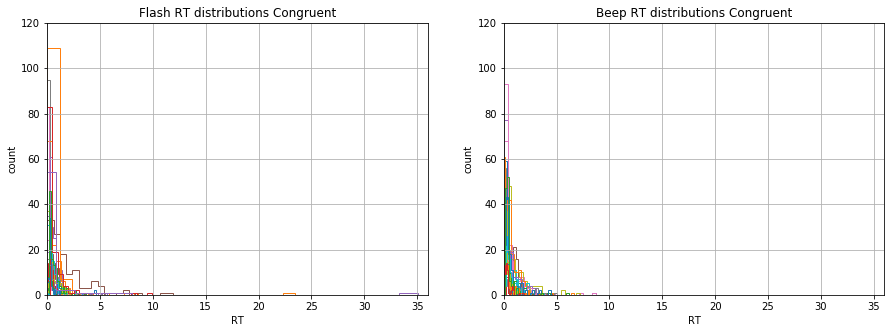

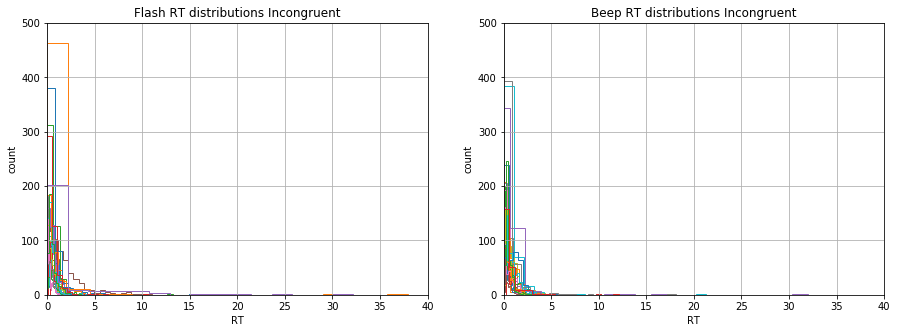

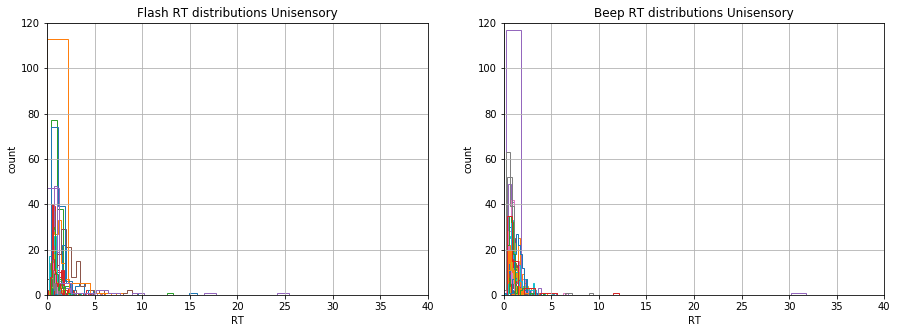

In [111]:
#test = hddm.utils.flip_errors(congfdata)

# compare congruent 
congfig = plt.figure(figsize=(15, 5))
ax = congfig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Congruent')
ax.set_xlim([0, 36])
ax.set_ylim([0, 120])
for i, subj_data in congfdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# one row has -1 rt

ax = congfig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Congruent')
ax.set_xlim([0, 36])
ax.set_ylim([0, 120])
for i, subj_data in congbdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# compare incongruent
incongfig = plt.figure(figsize=(15, 5))
ax = incongfig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Incongruent')
ax.set_xlim([0, 40])
ax.set_ylim([0, 500])
for i, subj_data in incongfdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

ax = incongfig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Incongruent')
ax.set_xlim([0, 40])
ax.set_ylim([0, 500])
for i, subj_data in incongbdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# compare unisensory 
unifig = plt.figure(figsize=(15, 5))
ax = unifig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Unisensory')
ax.set_xlim([0, 40])
ax.set_ylim([0, 120])
for i, subj_data in unifdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

ax = unifig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Unisensory')
ax.set_xlim([0, 40])
ax.set_ylim([0, 120])
for i, subj_data in unibdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)


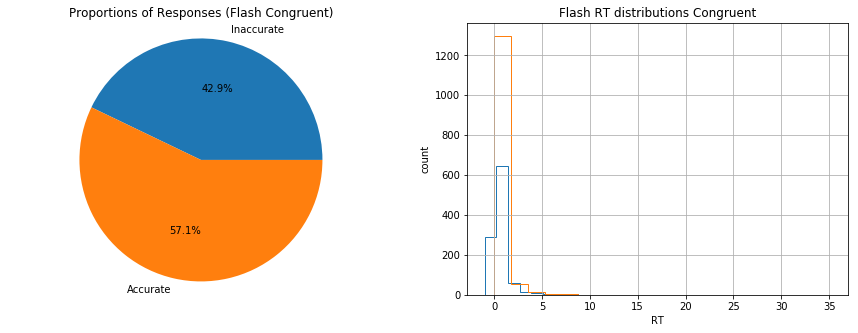

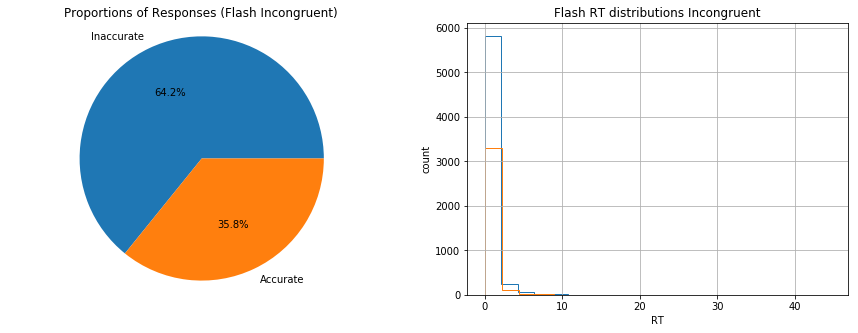

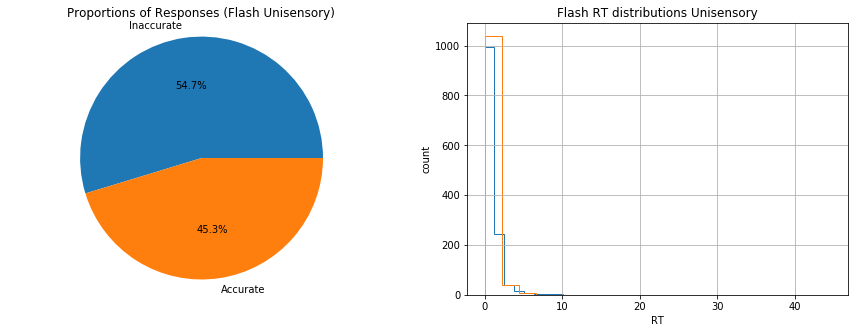

In [161]:
#print(congfdata['response'].value_counts())
sizes = [congfdata['response'].value_counts()[0], congfdata['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121, title='Proportions of Responses (Flash Congruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig.add_subplot(122, xlabel='RT', ylabel='count', title='Flash RT distributions Congruent')
for i, subj_data in congfdata.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
    
    
#print(incongfdata['response'].value_counts())
sizes = [incongfdata['response'].value_counts()[0], incongfdata['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig2 = plt.figure(figsize=(15, 5))
ax = fig2.add_subplot(121, title='Proportions of Responses (Flash Incongruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig2.add_subplot(122, xlabel='RT', ylabel='count', title='Flash RT distributions Incongruent')
for i, subj_data in incongfdata.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

    
#print(unifdata['response'].value_counts())
sizes = [unifdata['response'].value_counts()[0], unifdata['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig3 = plt.figure(figsize=(15, 5))
ax = fig3.add_subplot(121, title='Proportions of Responses (Flash Unisensory)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig3.add_subplot(122, xlabel='RT', ylabel='count', title='Flash RT distributions Unisensory')
for i, subj_data in unifdata.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

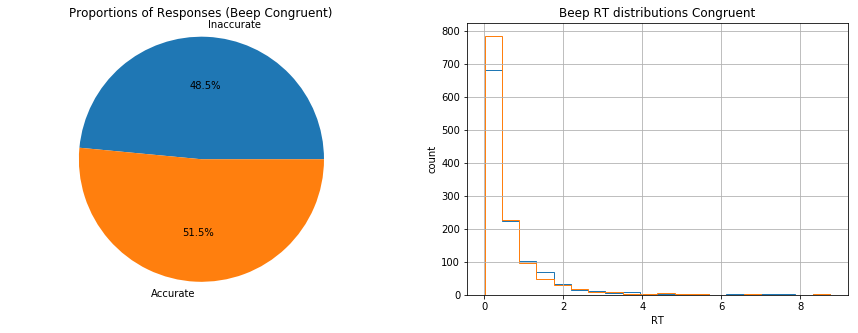

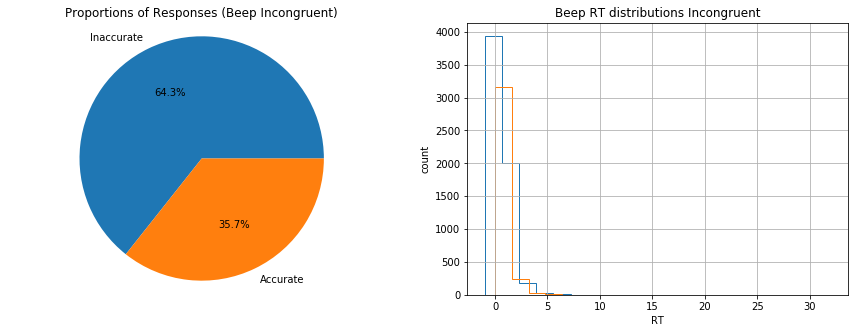

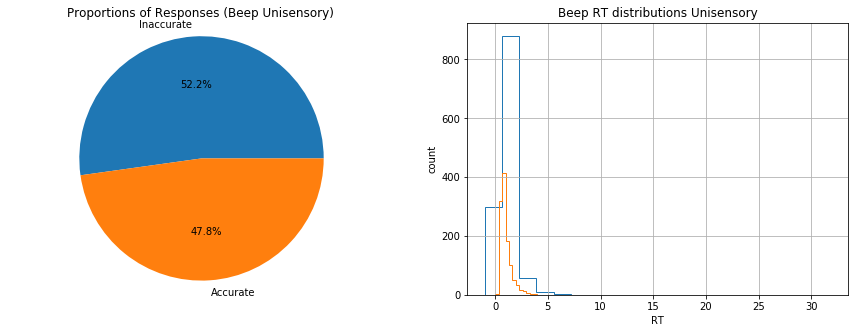

In [162]:
#print(congbdata['response'].value_counts())
sizes = [congbdata['response'].value_counts()[0], congbdata['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig4 = plt.figure(figsize=(15, 5))
ax = fig4.add_subplot(121, title='Proportions of Responses (Beep Congruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig4.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Congruent')
for i, subj_data in congbdata.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

    
#print(incongbdata['response'].value_counts())
sizes = [incongbdata['response'].value_counts()[0], incongbdata['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig5 = plt.figure(figsize=(15, 5))
ax = fig5.add_subplot(121, title='Proportions of Responses (Beep Incongruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig5.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Incongruent')
for i, subj_data in incongbdata.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
    
    
#print(unibdata['response'].value_counts())
sizes = [unibdata['response'].value_counts()[0], unibdata['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig6 = plt.figure(figsize=(15, 5))
ax = fig6.add_subplot(121, title='Proportions of Responses (Beep Unisensory)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig6.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Unisensory')
for i, subj_data in unibdata.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)